# Writing Kanji with an MDN-RNN

This example is similar to hardmaru's Kanji tutorial and the original Sketch-RNN repository.

- http://blog.otoro.net/2015/12/28/recurrent-net-dreams-up-fake-chinese-characters-in-vector-format-with-tensorflow/
- https://github.com/hardmaru/sketch-rnn

The idea is to learn how to draw kanji characters from a dataset of vector representations. This means learning how to move a pen in 3D space.

In the above examples, a 2D MDN was used to model the pen location and a separate distribution was used for the stroke ending. In this example, we will use one 3D MDN to model everything!

In [2]:
#Only for GPU use:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

In [3]:
import keras
from context import * # imports the MDN layer 
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib notebook

### First download and process the dataset.

In [4]:
# Train from David Ha's Kanji dataset from Sketch-RNN: https://github.com/hardmaru/sketch-rnn-datasets
# Other datasets in "Sketch 3" format should also work.

import urllib.request
url = 'https://github.com/hardmaru/sketch-rnn-datasets/raw/master/kanji/kanji.rdp25.npz'  
urllib.request.urlretrieve(url, './kanji.rdp25.npz')  

In [5]:
with np.load('./kanji.rdp25.npz') as data:
    train_set = data['train']
    valid_set = data['valid']
    test_set = data['test']

def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    print("Total training examples:", str(len(xs)))
    return xs

def seq_to_singleton_format(examples):
    """
    Return the examples in seq to singleton format.
    """
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

### Setup an MDN RNN and hyperparameters

- 2 RNN layers
- 256 LSTM units per RNN layer
- number of mixtures 5 (not 24 as in hardmaru's example)
- train for sequence length of 30
- try training for 500 epochs.

#### TODO: 

- gradient clipping (5.0)
- dropout (0.8)

In [6]:
# Training Hyperparameters:
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_UNITS = 256
EPOCHS = 100
SEED = 2345  # 2345 seems to be good.
random.seed(SEED)
np.random.seed(SEED)
# tf.set_random_seed(5791)  # only works for current graph.
OUTPUT_DIMENSION = 3
NUMBER_MIXTURES = 10

model = keras.Sequential()
model.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(None,SEQ_LEN,OUTPUT_DIMENSION), return_sequences=True))
model.add(keras.layers.LSTM(HIDDEN_UNITS))
model.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 256)           266240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
mdn_1 (MDN)                  (None, 3)                 17990     
Total params: 809,542
Trainable params: 809,542
Non-trainable params: 0
_________________________________________________________________


## Process the Data and Train the Model

Chop up the data into slices of the correct length, generate `X` and `y` for the training process.

In [7]:
# Prepare training data as X and Y.
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)
X, y = seq_to_singleton_format(slices)

X = np.array(X)
y = np.array(y)

print("X:", X.shape)
print("y:", y.shape)

Total training examples: 56
Total training examples: 31
Total training examples: 15
Total training examples: 40
Total training examples: 60
Total training examples: 28
Total training examples: 23
Total training examples: 11
Total training examples: 54
Total training examples: 45
Total training examples: 64
Total training examples: 8
Total training examples: 6
Total training examples: 55
Total training examples: 40
Total training examples: 7
Total training examples: 24
Total training examples: 5
Total training examples: 39
Total training examples: 67
Total training examples: 37
Total training examples: 38
Total training examples: 62
Total training examples: 33
Total training examples: 29
Total training examples: 17
Total training examples: 5
Total training examples: 57
Total training examples: 54
Total training examples: 0
Total training examples: 42
Total training examples: 46
Total training examples: 19
Total training examples: 46
Total training examples: 30
Total training examples: 5

Total training examples: 25
Total training examples: 38
Total training examples: 53
Total training examples: 29
Total training examples: 26
Total training examples: 55
Total training examples: 71
Total training examples: 19
Total training examples: 19
Total training examples: 7
Total training examples: 34
Total training examples: 35
Total training examples: 40
Total training examples: 26
Total training examples: 37
Total training examples: 18
Total training examples: 34
Total training examples: 44
Total training examples: 5
Total training examples: 15
Total training examples: 35
Total training examples: 33
Total training examples: 17
Total training examples: 71
Total training examples: 35
Total training examples: 36
Total training examples: 0
Total training examples: 3
Total training examples: 16
Total training examples: 29
Total training examples: 50
Total training examples: 59
Total training examples: 39
Total training examples: 79
Total training examples: 18
Total training examples:

Total training examples: 0
Total training examples: 25
Total training examples: 63
Total training examples: 32
Total training examples: 1
Total training examples: 18
Total training examples: 33
Total training examples: 26
Total training examples: 38
Total training examples: 64
Total training examples: 45
Total training examples: 66
Total training examples: 38
Total training examples: 46
Total training examples: 5
Total training examples: 69
Total training examples: 8
Total training examples: 34
Total training examples: 30
Total training examples: 30
Total training examples: 38
Total training examples: 30
Total training examples: 71
Total training examples: 0
Total training examples: 0
Total training examples: 63
Total training examples: 36
Total training examples: 57
Total training examples: 84
Total training examples: 19
Total training examples: 54
Total training examples: 38
Total training examples: 25
Total training examples: 1
Total training examples: 0
Total training examples: 25


Total training examples: 43
Total training examples: 24
Total training examples: 45
Total training examples: 34
Total training examples: 84
Total training examples: 32
Total training examples: 63
Total training examples: 0
Total training examples: 0
Total training examples: 0
Total training examples: 0
Total training examples: 2
Total training examples: 38
Total training examples: 28
Total training examples: 0
Total training examples: 48
Total training examples: 42
Total training examples: 44
Total training examples: 29
Total training examples: 64
Total training examples: 18
Total training examples: 58
Total training examples: 46
Total training examples: 0
Total training examples: 50
Total training examples: 34
Total training examples: 0
Total training examples: 27
Total training examples: 65
Total training examples: 40
Total training examples: 72
Total training examples: 47
Total training examples: 43
Total training examples: 46
Total training examples: 34
Total training examples: 21


X: (330546, 30, 3)
y: (330546, 3)


In [ ]:
# Fit the model

history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[keras.callbacks.TerminateOnNaN()])

Epoch 1/100
159296/330546 [=============>................] - ETA: 1:55 - loss: 8.2819

In [ ]:
model.save('kanji_mdnrnn_model.h5')  # creates a HDF5 file 'my_model.h5'

## Try out the model! Generate some Kanji!

We need to create a decoding model with batch size 1 and sequence length 1.

In [55]:
# Decoding Model
decoder = keras.Sequential()
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(1,1,OUTPUT_DIMENSION), return_sequences=True, stateful=True))
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, stateful=True))
decoder.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
decoder.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam())
decoder.summary()

decoder.set_weights(model.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (1, 1, 64)                17408     
_________________________________________________________________
lstm_12 (LSTM)               (1, 64)                   33024     
_________________________________________________________________
mdn_5 (MDN)                  (1, 3)                    2275      
Total params: 52,707
Trainable params: 52,707
Non-trainable params: 0
_________________________________________________________________


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

def zero_start_position():
    """A zeroed out start position with pen down"""
    out = np.zeros((1, 1, 3), dtype=np.float32)
    out[0, 0, 2] = 1 # set pen down.
    return out

def generate_sketch(model, start_pos, num_points=100):
     return None

def cutoff_stroke(x):
    return np.greater(x,0.5) * 1.0

def plot_sketch(sketch_array):
    """Plot a sketch quickly to see what it looks like."""
    sketch_df = pd.DataFrame({'x':sketch_array.T[0],'y':sketch_array.T[1],'z':sketch_array.T[2]})
    sketch_df.x = sketch_df.x.cumsum()
    sketch_df.y = sketch_df.y.cumsum()
    # Do the plot
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    #ax1.scatter(sketch_df.x,sketch_df.y,marker='o', c='r', alpha=1.0)
    # Need to do something with sketch_df.z
    ax1.plot(sketch_df.x,sketch_df.y,'r-')
    plt.show()

# plot_sketch(train_set[5])

In [188]:
# Hardmaru's Drawing Functions from write-rnn-tensorflow
# Big hat tip
# Here's the source:
# https://github.com/hardmaru/write-rnn-tensorflow/blob/master/utils.py

import svgwrite
from IPython.display import SVG, display


def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

def draw_strokes(data, factor=10, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))

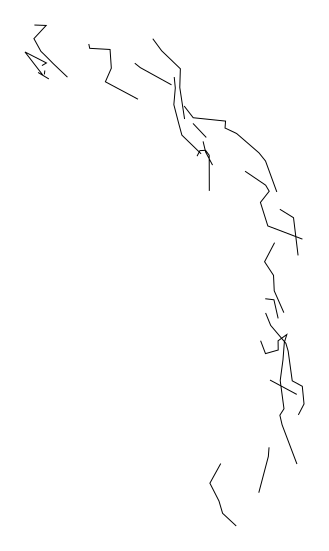

<IPython.core.display.Javascript object>


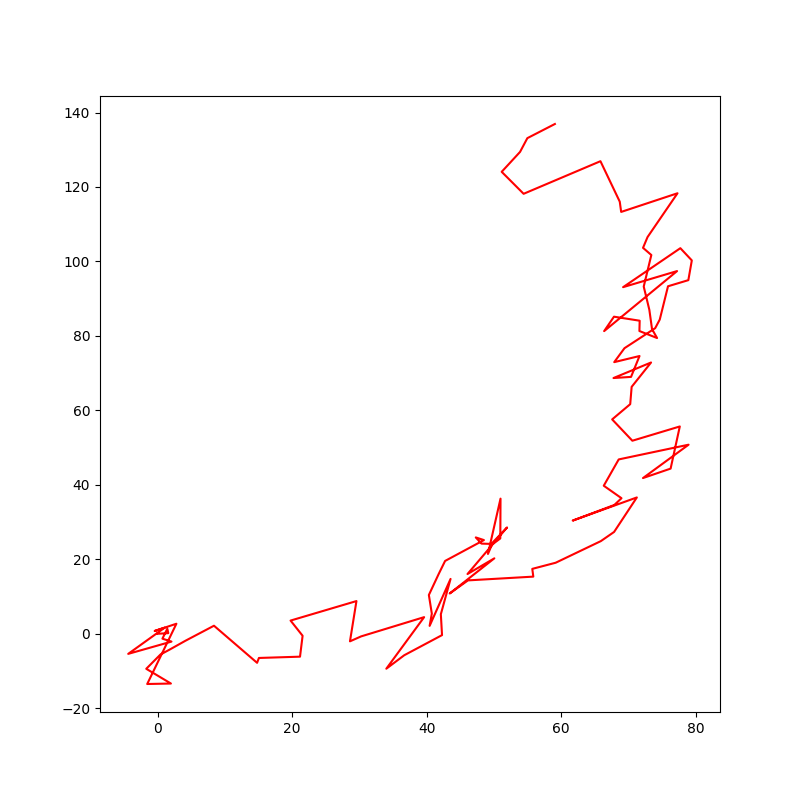

In [195]:
# Predict a character and plot the result.

p = zero_start_position()
sketch = [p.reshape(3,)]

for i in range(100):
    params = decoder.predict(p.reshape(1,1,3))
    p = mdn.sample_from_output(params[0], NUMBER_MIXTURES, OUTPUT_DIMENSION, temp=1.0)
    sketch.append(p.reshape((3,)))

sketch = np.array(sketch)
decoder.reset_states()

sketch.T[2] = cutoff_stroke(sketch.T[2])
draw_strokes(sketch, factor=0.3)
plot_sketch(sketch)